# NORDEUS DATA SCIENCE CHALLENGE 2023

## Introduction

The challenge for this year is to create and train an ML model on an already defined problem and prepared data. The problem is clearly defined - for the needs of the matchmaking algorithm, we want to predict the position in the table at the end of the season for each club.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error



from sklearn.preprocessing import OneHotEncoder

def load_csv_data(filename):
    pwd = os.getcwd()
    filepath_train_test = os.path.join(pwd, filename)
    return pd.read_csv(filepath_train_test)

train_data = load_csv_data("jobfair_train.csv")
train_data

,season,club_id,league_id,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,...,registration_country,registration_platform_specific,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
0,173,6042825,2912348,2) Minnow,134,25,5.255151,4.483009,1.778801,25,...,Portugal,Flash FB Canvas,24,435,11.0,598,245,186,818,2
1,173,9620967,2912140,2) Minnow,28,23,4.962521,4.785648,-0.002687,28,...,Turkey,Android Phone,19,58,7.0,269,0,35,24,2
2,173,6045474,2912933,4) Whale,136,23,11.105782,10.511133,0.628794,28,...,Belgium,Flash FB Canvas,26,116,8.0,23180,369,444,4933,1
3,173,14187773,2910371,0) NonPayer,2,21,4.164848,4.023486,0.551904,12,...,Malaysia,Android Phone,11,22,2.0,41,43,213,126,6
4,173,13694853,2907632,0) NonPayer,5,22,3.031939,2.926029,0.690544,0,...,Italy,iOS Phone,9,0,4.0,0,16,100,147,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55309,173,14278145,2906514,0) NonPayer,2,25,4.160909,3.948086,0.503241,11,...,Switzerland,iOS Phone,13,25,NaN,42,10,25,37,1
55310,173,14309556,2906913,2) Minnow,2,21,4.244145,3.762286,0.664514,28,...,France,iOS Phone,25,167,NaN,214,158,358,256,1
55311,173,14455654,2905985,0) NonPayer,1,21,4.000158,3.753276,0.507620,6,...,France,iOS Tablet,14,17,NaN,73,11,70,57,11
55312,173,13623733,2910437,0) NonPayer,5,24,4.582158,4.461391,0.664767,28,...,Morocco,Android Phone,22,80,4.0,90,65,109,150,5


## Glancing and preprocessing

To begin with, we look at the data itself, attributes, their types, quality, occupancy... What I conclude is the following:
- To begin with, we see that the data is quite organized, there are no missing data, except for the *global_competition_level* attribute, most of the attributes are of numeric type (int/float), except for *dynamic_payment_segment* (which in the name specifies the number of consumption tracks), *registration_county*, and *registration_platform_specific*, which are strings, so we'll have to convert them somehow.
- What I wanted to check at the beginning, and what turned out to be correct, is that for each league all the teams from it are given, so we have almost 4000 leagues, with 14 teams in each. Since we have data for entire leagues, it means that the distribution of the *league_rank* - target attribute is equal
- I had to check the test set as well, there we have about 4300 leagues, also 14 teams from each. We have more clubs, of which 32k are the same as in the test set, and 28k are some new clubs.

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55314 entries, 0 to 55313
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   season                                   55314 non-null  int64  
 1   club_id                                  55314 non-null  int64  
 2   league_id                                55314 non-null  int64  
 3   dynamic_payment_segment                  55314 non-null  object 
 4   cohort_season                            55314 non-null  int64  
 5   avg_age_top_11_players                   55314 non-null  int64  
 6   avg_stars_top_11_players                 55314 non-null  float64
 7   avg_stars_top_14_players                 55314 non-null  float64
 8   avg_training_factor_top_11_players       55314 non-null  float64
 9   days_active_last_28_days                 55314 non-null  int64  
 10  league_match_watched_count_last_28_days  55314

In [7]:
train_data["dynamic_payment_segment"].value_counts()

0) NonPayer    41843
2) Minnow       6047
1) ExPayer      5025
3) Dolphin      1854
4) Whale         545
Name: dynamic_payment_segment, dtype: int64

In [8]:
#train_data["league_id"].value_counts()
#train_data["registration_country"].value_counts()
train_data["registration_platform_specific"].value_counts()

Android Phone               35859
iOS Phone                    9896
Flash FB Canvas              4340
Android Tablet               1867
iOS Tablet                   1214
UniversalWindows PC           724
WebGL FB Canvas               702
WebGL TE Site                 489
WebGL or Flash FB Canvas      129
Flash TE Site                  77
WebGL or Flash TE Site         17
Name: registration_platform_specific, dtype: int64

In [9]:
train_data.describe()

,season,club_id,league_id,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,league_match_watched_count_last_28_days,session_count_last_28_days,playtime_last_28_days,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
count,55314.0,5.531400e+04,5.531400e+04,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000,5.531400e+04,55314.000000,55314.000000,37763.000000,55314.000000,55314.000000,55314.000000,55314.000000,55314.000000
mean,173.0,1.210977e+07,2.909804e+06,23.409372,23.718661,4.533516,4.344776,0.584372,12.357089,3.623170,63.432169,2.955178e+07,12.411813,61.107694,3.901014,121.393897,113.133077,283.083523,307.085964,7.500000
std,0.0,3.384016e+06,2.102140e+03,42.009274,2.206240,1.204753,1.177068,0.178090,11.849102,5.906055,101.831670,5.233892e+07,6.403013,188.288285,2.625576,842.775529,3183.550398,789.250959,823.362486,4.031165
min,173.0,2.750000e+02,2.904743e+06,1.000000,18.000000,1.451697,1.354905,-1.287736,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,-4975.000000,-169.000000,0.000000,1.000000
25%,173.0,1.151105e+07,2.907961e+06,2.000000,22.000000,3.691136,3.500062,0.479571,1.000000,0.000000,1.000000,7.364150e+04,8.000000,0.000000,1.000000,0.000000,11.000000,41.000000,52.000000,4.000000
50%,173.0,1.392822e+07,2.910038e+06,4.000000,23.000000,4.481376,4.311590,0.561158,7.000000,0.000000,16.000000,6.230431e+06,12.000000,11.000000,3.000000,38.000000,29.000000,88.000000,118.000000,7.500000
75%,173.0,1.424454e+07,2.911697e+06,17.000000,25.000000,5.217394,5.021726,0.648180,27.000000,5.000000,89.000000,3.768711e+07,17.000000,63.000000,6.000000,107.000000,73.000000,243.000000,281.000000,11.000000
max,173.0,1.451477e+07,2.912940e+06,172.000000,33.000000,23.716073,20.434876,5.164494,28.000000,26.000000,1365.000000,1.340479e+09,26.000000,7443.000000,11.000000,120233.000000,744202.000000,32767.000000,32767.000000,14.000000


## Data distribution check

Before further steps, I want to see what is the distribution of our attributes. Due to the "heavy tail", it would be good to do logarithmic transformation-scaling for the following attributes in order to obtain a normal distribution:
- morale_boosters_stash ->log
- rests_stash -> log
- tokens_stash->log
- tokens_spent_last_28_days -> log
- training_count_last_28_days->log
- session_count_last_28_days-> sqrt

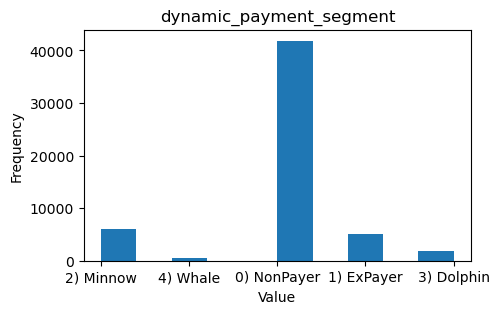

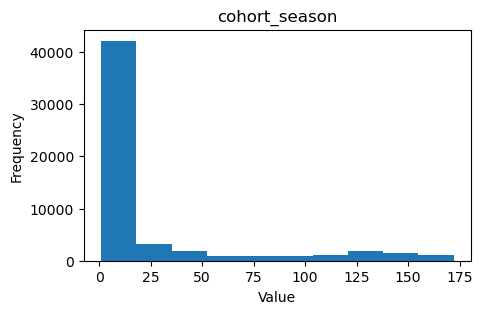

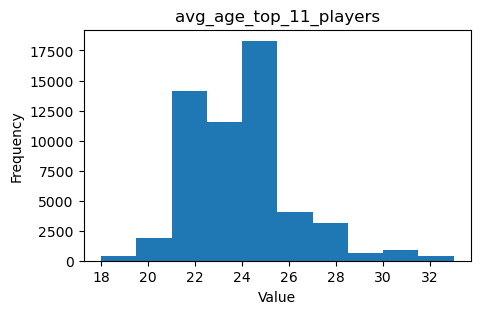

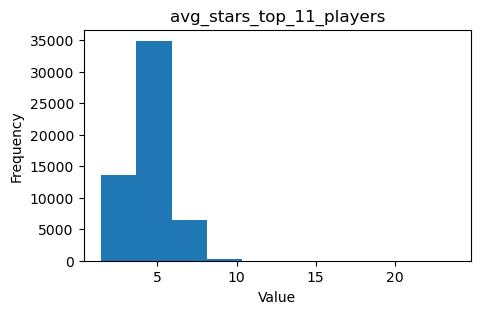

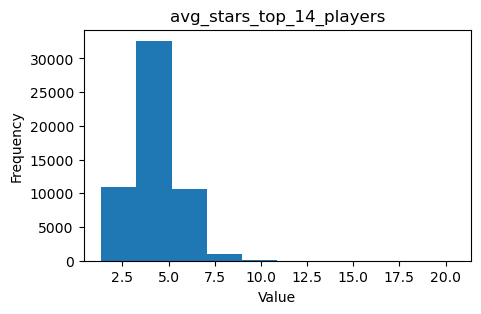

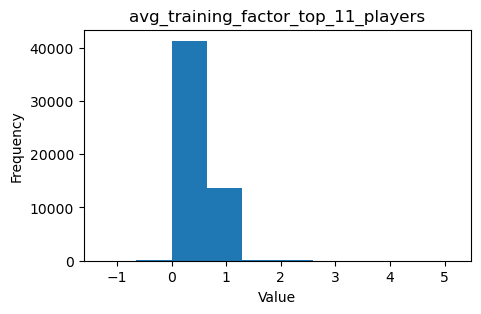

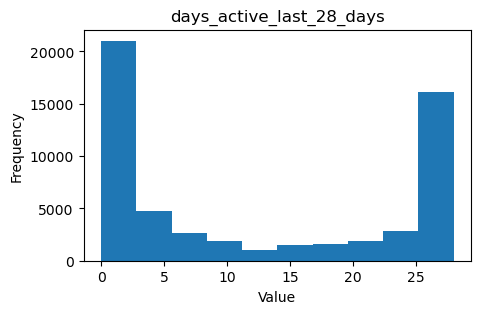

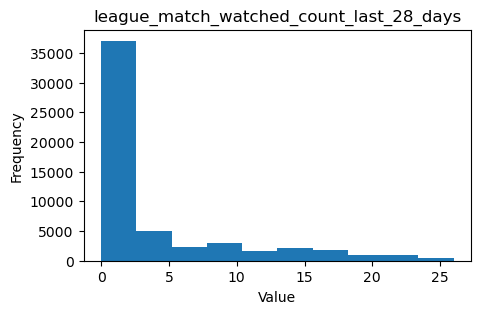

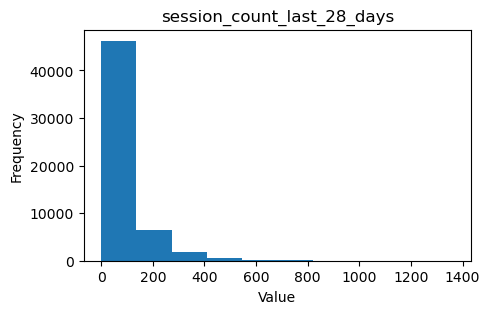

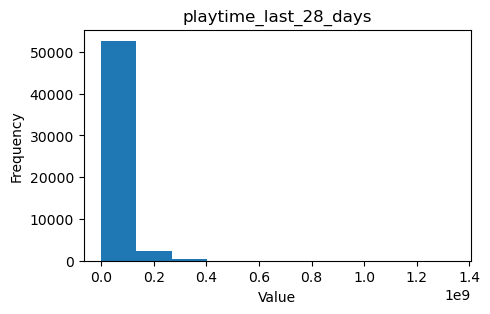

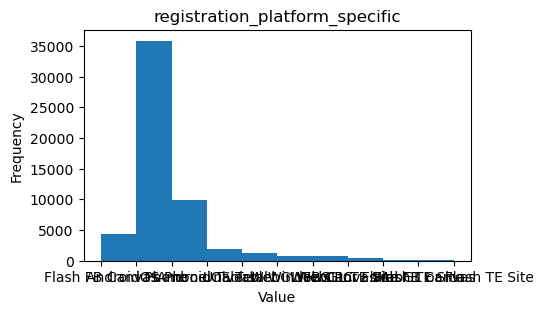

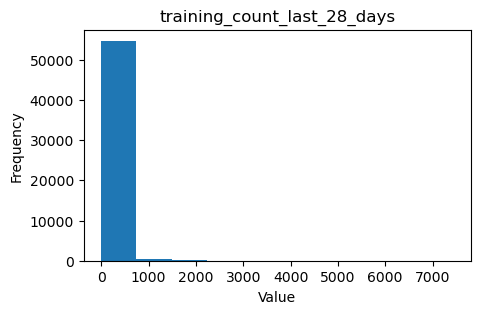

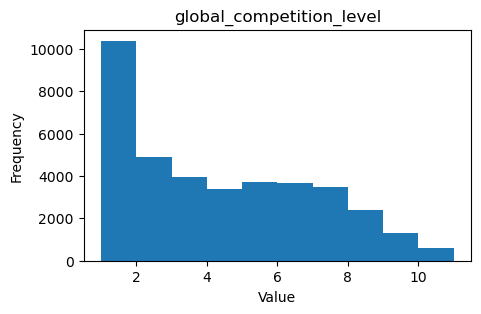

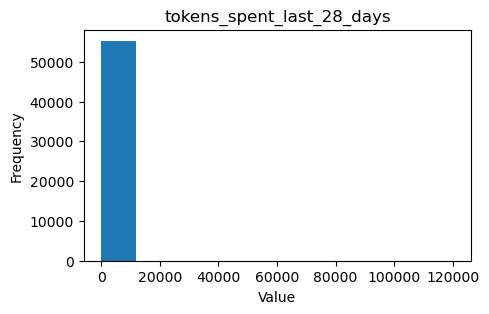

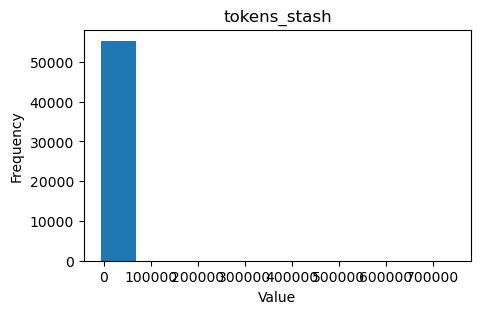

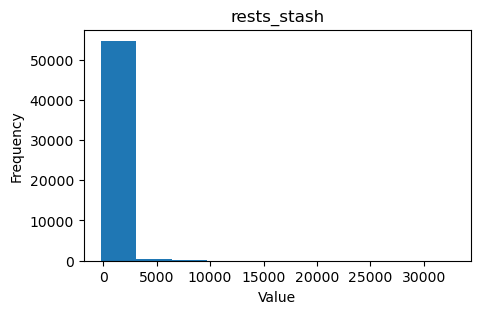

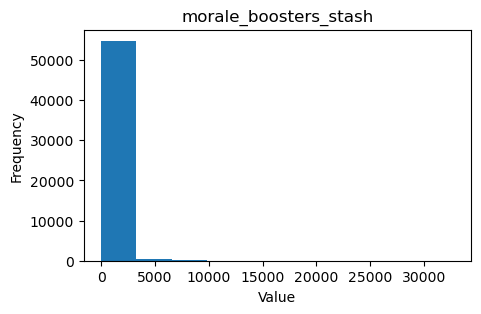

In [77]:
attr_ind = [3,4,5,6,7,8,9,10,11,12,14,16,17,18,19,20,21]
selected_attibutes3 = train_data.iloc[:,attr_ind]

fig_width = 5
fig_height = 3
for idx, column in enumerate(selected_attibutes3.columns):
    plt.figure(idx, figsize=(fig_width, fig_height))  # Create a new figure for each histogram
    plt.hist(selected_attibutes3[column], bins=10)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'{column}')
    plt.show()

In [11]:
train_data_copy = train_data.copy()

- At this point, we would split the data into a validation set, however we will use cross-validation, so there is no need for splitting.

C:\Users\Mirko\AppData\Local\Temp\ipykernel_12704\3995916031.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[data1 <=0] = np.nan


<Axes: >

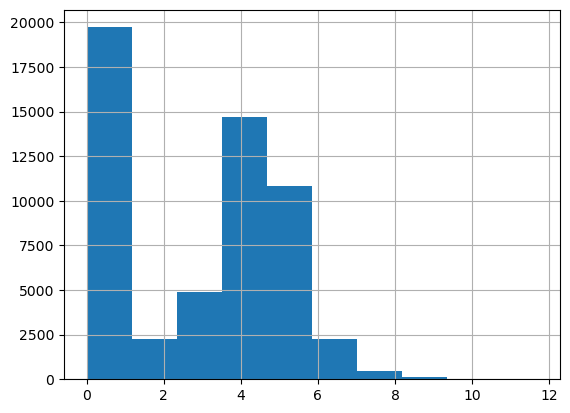

In [12]:
data1 = train_data_copy["tokens_spent_last_28_days"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_token_spent1 = np.log(data1.replace(np.nan, 1))
train_data_copy["tokens_spent_last_28_days"] = log_token_spent1
log_token_spent1.hist()

<Axes: >

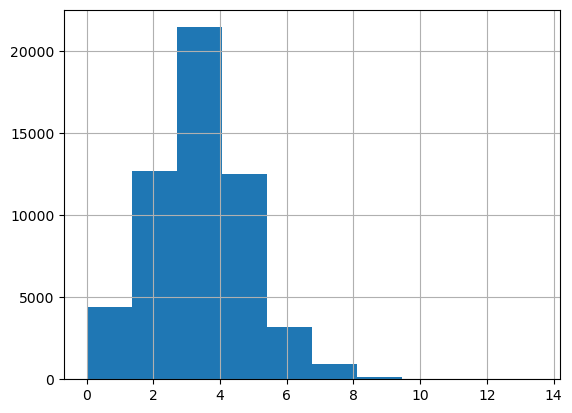

In [42]:
data1 = train_data_copy["tokens_stash"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_token_stash1 = np.log(data1.replace(np.nan, 1))
train_data_copy["tokens_stash"] = log_token_stash1
log_token_stash1.hist()

C:\Users\Mirko\AppData\Local\Temp\ipykernel_12704\2126297463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[data1 <=0] = np.nan


<Axes: >

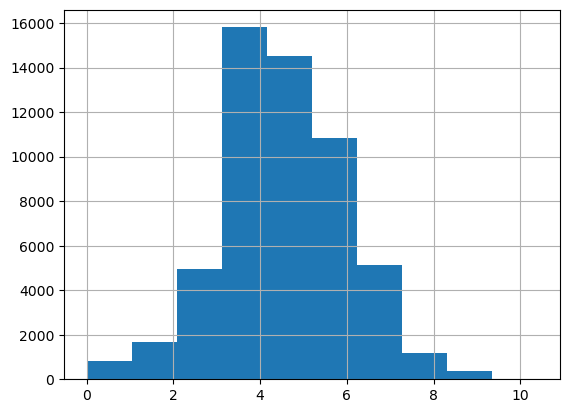

In [14]:

data1 = train_data_copy["rests_stash"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_rest_stash1 = np.log(data1.replace(np.nan, 1))
train_data_copy["rests_stash"] = log_rest_stash1
log_rest_stash1.hist()

C:\Users\Mirko\AppData\Local\Temp\ipykernel_12704\1773690644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[data1 <=0] = np.nan


<Axes: >

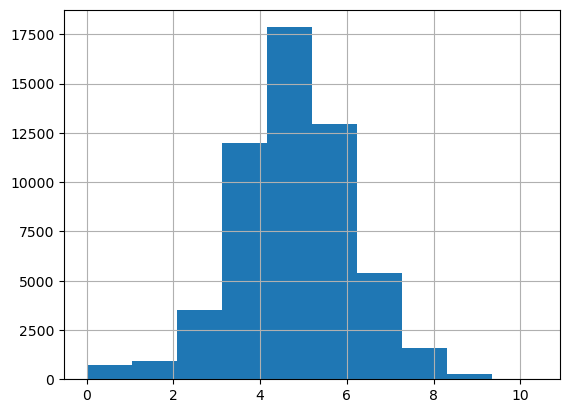

In [15]:
data1 = train_data_copy["morale_boosters_stash"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_moral_stash1 = np.log(data1.replace(np.nan, 1))
train_data_copy["morale_boosters_stash"] = log_moral_stash1
log_moral_stash1.hist()

C:\Users\Mirko\AppData\Local\Temp\ipykernel_12704\3682899775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[data1 <=0] = np.nan


<Axes: >

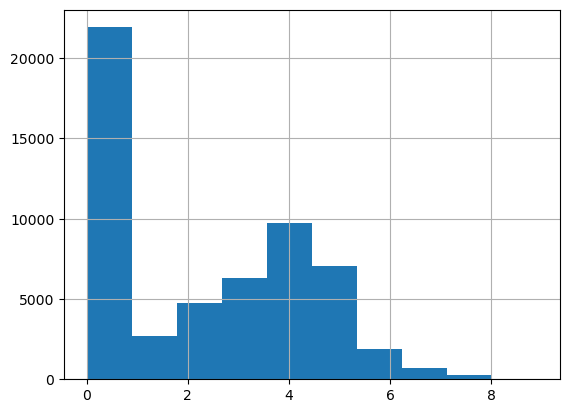

In [16]:

data1 = train_data_copy["training_count_last_28_days"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_tr = np.log(data1.replace(np.nan, 1))
train_data_copy["training_count_last_28_days"] = log_tr
log_tr.hist()

<Axes: >

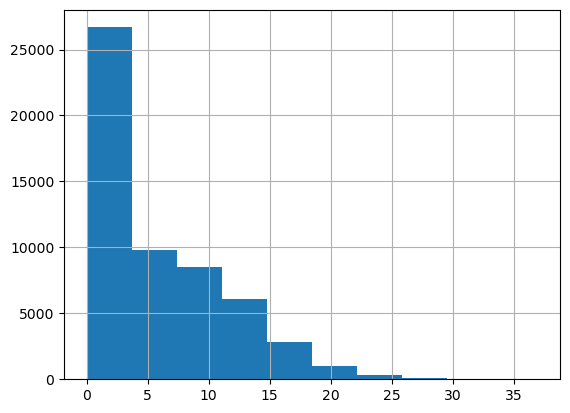

In [17]:
	
data1 = train_data_copy["session_count_last_28_days"]

sq_ss = np.sqrt(data1)
train_data_copy["session_count_last_28_days"] = sq_ss
sq_ss.hist()

### What we need to do:

-"GlobalCompetitonLevel" null -> 0
-We have objects for PayingSegment, Countries, and Devices, we need to encode/clear those attributes
-    For "PayingSegment" the categories are already given in the name, so we will simply encode them (it also makes sense to code like this - the larger the id, the larger the amount spent)
- "Country" will be encoded using target_encoder - we have a large number of categories, assigning ids in some order does not make any sense, and there are too many categories to create an attribute for each of them.
- For Devices we can do oneHotEncodig (and group rare categories), but I choose to just drop the whole attribute.

- Check what is happening at the league level
- Check the correlations
- Can attributes be merged/replaced/dropped

- We will drop both season (does not provide information), and "avg_stars_top_14_players" (High correlation with avg_stars_top_11_players)

In [25]:

#-----paying segment encoding-------
def encode_paying_segment(train_data_copy, column_to_encode):
    train_data_copy[column_to_encode] = train_data_copy[column_to_encode].str.extract('(\d+)', expand=False).astype(float)
    return train_data_copy
#train_data_copy = encode_paying_segment(train_data_copy, "dynamic_payment_segment")


#------global competition level imput-------
train_data_copy["global_competition_level"].fillna(0,inplace=True)



In [78]:
corr_matrix = train_data_copy.corr()

#corr_matrix["league_rank"].sort_values(ascending=False)
#corr_matrix["avg_stars_top_11_players"].sort_values(ascending=False)
#corr_matrix["training_count_last_28_days"].sort_values(ascending=False)
#corr_matrix["cohort_season"].sort_values(ascending=False)
#corr_matrix["league_match_won_count_last_28_days"].sort_values(ascending=False)


In [27]:
#--------country encoding---------
def target_encode(df, cat_column, target_column):
    unique_cats = df[cat_column].unique()
    global_mean = df[target_column].mean()  # Global mean of the target variable

    encoding_map = {}
    for cat in unique_cats:
        cat_mean = df[df[cat_column] == cat][target_column].mean()
        if pd.notnull(cat_mean):  # Handle missing values
            encoding_map[cat] = cat_mean
        else:
            encoding_map[cat] = global_mean  # Use global mean for missing values

    df[f'{cat_column}_encoded'] = df[cat_column].map(encoding_map)
    return df, encoding_map

train_data_copy, country_encoding_map = target_encode(train_data_copy, "registration_country", "league_rank")
joblib.dump(country_encoding_map, "country_encoding_map.joblib")

train_data_copy.drop('registration_country', axis=1, inplace=True)  # Assuming 'X_train' is your training data



In [43]:
#------registration_platform_specific drop, season drop, avg_stars_top_14_players drop -----
#train_data_copy = train_data_copy.drop(["registration_platform_specific", "season", "avg_stars_top_14_players"], axis=1)

train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55314 entries, 0 to 55313
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   club_id                                  55314 non-null  int64  
 1   league_id                                55314 non-null  int64  
 2   dynamic_payment_segment                  55314 non-null  float64
 3   cohort_season                            55314 non-null  int64  
 4   avg_age_top_11_players                   55314 non-null  int64  
 5   avg_stars_top_11_players                 55314 non-null  float64
 6   avg_training_factor_top_11_players       55314 non-null  float64
 7   days_active_last_28_days                 55314 non-null  int64  
 8   league_match_watched_count_last_28_days  55314 non-null  int64  
 9   session_count_last_28_days               55314 non-null  float64
 10  playtime_last_28_days                    55314

- Now all that's left is to do the standardization and we're ready for Testing the Algorithms

In [44]:
y = train_data_copy["league_rank"]
x = train_data_copy.drop("league_rank", axis=1)

num_cols = [col for col in x.columns if col not in['club_id', 'league_id']]

scaler = StandardScaler()
x[num_cols] = scaler.fit_transform(x[num_cols])

## Select and Train model

So far we have explored the data, did EDA and preprocessing, and prepared it for ML algorithms

First, we will see how a couple of regression algorithms behave

In [54]:
from sklearn.linear_model import LinearRegression


num_splits = 5  # Choose the number of splits
group_kfold = GroupKFold(n_splits=num_splits)

mae_scores = []  # To store the MAE scores for each fold

for train_idx, val_idx in group_kfold.split(x, y, groups=x["league_id"]):
    # Split the data into training and validation sets based on indices
    X_train_fold, X_val_fold = x.iloc[train_idx], x.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Initialize and train the model on the current fold
    
    lin_model1 = LinearRegression()
    lin_model1.fit(X_train_fold, y_train_fold)

    # Predict on the validation set for the current fold
    y_pred_fold = lin_model1.predict(X_val_fold)

    # Calculate and store the MAE for this fold
    mae_fold = mean_absolute_error(y_val_fold, y_pred_fold)
    mae_scores.append(mae_fold)

# Calculate the mean MAE across all folds
mean_mae = sum(mae_scores) / len(mae_scores)
print(f"Mean Absolute Error across {num_splits} folds: {mean_mae}")


Mean Absolute Error across 5 folds: 2.5187682516167347


In [58]:
from sklearn.ensemble import RandomForestRegressor

num_splits = 5  # Choose the number of splits
group_kfold = GroupKFold(n_splits=num_splits)

mae_scores = []  # To store the MAE scores for each fold

for train_idx, val_idx in group_kfold.split(x, y, groups=x["league_id"]):
    # Split the data into training and validation sets based on indices
    X_train_fold, X_val_fold = x.iloc[train_idx], x.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Initialize and train the model on the current fold
    
    rf_model1 = RandomForestRegressor()
    rf_model1.fit(X_train_fold, y_train_fold)

    # Predict on the validation set for the current fold
    y_pred_fold = rf_model1.predict(X_val_fold)

    # Calculate and store the MAE for this fold
    mae_fold = mean_absolute_error(y_val_fold, y_pred_fold)
    mae_scores.append(mae_fold)

# Calculate the mean MAE across all folds
mean_mae = sum(mae_scores) / len(mae_scores)
print(f"Mean Absolute Error across {num_splits} folds: {mean_mae}")

Mean Absolute Error across 5 folds: 2.2629968206975857


In [57]:
from sklearn.ensemble import GradientBoostingRegressor

num_splits = 5  # Choose the number of splits
group_kfold = GroupKFold(n_splits=num_splits)

mae_scores = []  # To store the MAE scores for each fold

for train_idx, val_idx in group_kfold.split(x, y, groups=x["league_id"]):
    # Split the data into training and validation sets based on indices
    X_train_fold, X_val_fold = x.iloc[train_idx], x.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Initialize and train the model on the current fold
    gbr_model1 = GradientBoostingRegressor()
    gbr_model1.fit(X_train_fold, y_train_fold)

    # Predict on the validation set for the current fold
    y_pred_fold = gbr_model1.predict(X_val_fold)

    # Calculate and store the MAE for this fold
    mae_fold = mean_absolute_error(y_val_fold, y_pred_fold)
    mae_scores.append(mae_fold)

# Calculate the mean MAE across all folds
mean_mae = sum(mae_scores) / len(mae_scores)
print(f"Mean Absolute Error across {num_splits} folds: {mean_mae}")


Mean Absolute Error across 5 folds: 2.337012129809159


## RankNet - pairwise LTR

- This group of algorithms is used in searches, recommenders, documents... but the idea itself pretty much matches what we need to do here.
The idea is not to look at the entire set of data, but to see from a subset which result is more relevant for us.
- The idea is not to look at the entire set of data, but to see from a subset which result is more relevant for us. One of the approaches is to map the query Q itself, which fetches the corresponding results q1,q2..qn, with each pair of fetched results, and to find out which one is more relevant between them: F(Q, q1,q2)=1 F(Q, q1, qn)=0. This is very reminiscent of the data we have, even the game of football itself. Q would be the league id, and q1, q2 would be the club id, with their attributes, and the result would be easily obtained by comparing the rank at the end of the season.
- However, the implementation of this is not so simple. I struggled for a few days, but in the end I didn't succeed.
- however, I'll leave the code in a comment, and briefly explain what the idea was

In [ ]:
"""X_pairs = []
y_pairs = []
groups = []

# Iterate through each league
for league_id in train_data_copy['league_id'].unique():
    league_data = train_data_copy[train_data_copy['league_id'] == league_id]
    

    # Create pairs within the league
    for i in range(len(league_data)):
        for j in range(i+1, len(league_data)):
            club1 = league_data.iloc[i]
            club2 = league_data.iloc[j]

            groups.append(league_id)

            # Create a feature vector for the pair
            pair_features = [league_id] + club1.tolist()[:-1] + club2.tolist()[:-1] # Excluding the league_rank from features
            X_pairs.append(pair_features)

            # Determine the label for the pair
            label = 1 if club1['league_rank'] < club2['league_rank'] else 0  # Assuming lower rank number is better
            y_pairs.append(label)

# Convert to numpy arrays or DataFrame as per requirement
X_pairs = np.array(X_pairs)
y_pairs = np.array(y_pairs)"""


In [61]:
"""def predict_rankings(model, league_data):
    num_clubs = len(league_data)
    scores = np.zeros(num_clubs)

    for i in range(num_clubs):
        for j in range(num_clubs):
            if i != j:
                # Create the pair for prediction
                pair_features = np.concatenate([league_data[i], league_data[j]])
                pair_features = pair_features.reshape(1, -1)  # Reshape for the model

                # Predict with RankNet model
                prediction = model.predict(pair_features)

                # Aggregate scores
                if prediction > 0.5:
                    scores[i] += 1
                else:
                    scores[j] += 1

    rankings = np.argsort(-scores) + 1  # Convert scores to rankings
    return rankings"""

In [ ]:
"""def create_ranknet_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Output layer for ranking
    ])
    return model

n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)
mae_scores = []

for train_idx, test_idx in group_kfold.split(X_pairs, y_pairs, groups):
    X_train, X_test = X_pairs[train_idx], X_pairs[test_idx]
    y_train, y_test = y_pairs[train_idx], y_pairs[test_idx]

    # Train the model
    model1 = create_ranknet_model(input_shape=(X_train.shape[1],))
    model1.compile(optimizer='adam', loss='binary_crossentropy')
    model1.fit(X_train, y_train, epochs=10, batch_size=32)

    # Predict rankings for each league in the test set
    test_leagues = np.unique(groups[test_idx])
    league_mae_scores = []

    for league_id in test_leagues:
        # Extract original non-pairwise test data for this league
        league_indices = np.where(groups == league_id)[0]
        league_data = x.iloc[league_indices]  # Extract from original data
        true_rankings = y[league_indices]  # Extract from original labels

        predicted_rankings = predict_rankings(model1, league_data)

        # Calculate MAE for this league
        mae = mean_absolute_error(true_rankings, predicted_rankings)
        league_mae_scores.append(mae)

    # Average MAE for this fold
    fold_mae = np.mean(league_mae_scores)
    mae_scores.append(fold_mae)

# Overall performance
average_mae = np.mean(mae_scores)
print(f"Average MAE across folds: {average_mae}")"""

we need to apply the same transformations to the test data

In [83]:
test_data = load_csv_data("jobfair_test.csv")

test_data = encode_paying_segment(test_data, "dynamic_payment_segment")
test_data["global_competition_level"].fillna(0, inplace=True)

test_data=test_data.drop(["registration_platform_specific", "season", "avg_stars_top_14_players"], axis=1)


In [92]:
saved_encoder = joblib.load("country_encoding_map.joblib")
default_value = 7.5
test_data['registration_country_encoded'] = test_data['registration_country'].map(saved_encoder).fillna(default_value)

In [ ]:
test_data.drop("registration_country", axis=1, inplace=True)

In [ ]:
data1 = test_data["tokens_spent_last_28_days"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_token_spent1 = np.log(data1.replace(np.nan, 1))
test_data["tokens_spent_last_28_days"] = log_token_spent1

In [ ]:
data1 = test_data["tokens_stash"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_token_stash1 = np.log(data1.replace(np.nan, 1))
test_data["tokens_stash"] = log_token_stash1

In [ ]:
data1 = test_data["rests_stash"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_rest_stash1 = np.log(data1.replace(np.nan, 1))
test_data["rests_stash"] = log_rest_stash1

In [ ]:
data1 = test_data["morale_boosters_stash"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_moral_stash1 = np.log(data1.replace(np.nan, 1))
test_data["morale_boosters_stash"] = log_moral_stash1

In [ ]:
data1 = test_data["training_count_last_28_days"]
zero_or_less_values = data1[data1<=0]
if len(zero_or_less_values) > 0:
    data1[data1 <=0] = np.nan

log_tr = np.log(data1.replace(np.nan, 1))
test_data["training_count_last_28_days"] = log_tr

In [101]:
data1 = test_data["session_count_last_28_days"]

sq_ss = np.sqrt(data1)
test_data["session_count_last_28_days"] = sq_ss

In [107]:
num_cols = [col for col in test_data.columns if col not in['club_id', 'league_id']]

scaler = StandardScaler()
test_data[num_cols] = scaler.fit_transform(test_data[num_cols])

In [109]:
y_test_data = rf_model1.predict(test_data)

In [110]:
final_rankings = [int(round(res))for res in y_test_data]

In [111]:
league_rank_predictions = pd.DataFrame({"club_id":test_data["club_id"], "predicted_league_rank":final_rankings})
league_rank_predictions.to_csv("league_rank_predictions.csv", index=False)